# Задача 7. Компьютерное зрение: задача сегментации

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


- [X] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [X] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [X] Попробовать улучшить качество изменяя архитектуру.
- [X] * (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [X] * (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [ ]:
import os
import random
import zipfile

import albumentations as A
import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Dataset

## Подготовка к экспериментам

### Утилиты

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def jaccard_index(preds, targets, smooth=1e-6):
    preds = (preds > 0.5).float()
    targets = targets.float()

    assert (
        preds.dim() == 4
    ), f"Predictions should have 4 dimensions (B, C, H, W), but got {preds.dim()}"
    assert (
        targets.dim() == 4
    ), f"Targets should have 4 dimensions (B, C, H, W), but got {targets.dim()}"
    assert (
        preds.shape == targets.shape
    ), f"Predictions shape {preds.shape} must match targets shape {targets.shape}"

    intersection = (preds * targets).sum((1, 2, 3))
    union = (preds + targets).sum((1, 2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


def visualize_worst_preds(
    model_or_preds, dataset, device, N=5, transform=None, is_preds_list=False
):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    errors = []

    if is_preds_list:
        print("Visualizing using pre-computed predictions.")
        idx = 0
        for img_batch, mask_batch in loader:
            if idx >= len(model_or_preds):
                print(f"Warning: Ran out of pre-computed predictions at index {idx}.")
                break
            pred = model_or_preds[idx].unsqueeze(0)
            img, mask = img_batch.to(device), mask_batch.to(device)
            iou = jaccard_index(pred.to(device), mask).item()
            errors.append((iou, img_batch.cpu(), mask_batch.cpu(), pred.cpu()))
            idx += 1
    else:
        print("Visualizing using model inference.")
        model = model_or_preds
        model.eval()
        with torch.no_grad():
            for img_batch, mask_batch in loader:
                img, mask = img_batch.to(device), mask_batch.to(device)
                pred = model(img)
                iou = jaccard_index(pred, mask).item()
                errors.append((iou, img.cpu(), mask.cpu(), pred.cpu()))

    errors.sort(key=lambda x: x[0])

    print(f"Visualizing {min(N, len(errors))} worst predictions...")
    for i in range(min(N, len(errors))):
        iou, img_tensor, mask_tensor, pred_tensor = errors[i]

        img_display = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
        mask_display = mask_tensor.squeeze(0).squeeze(0).numpy()
        pred_display = pred_tensor.squeeze(0).squeeze(0).numpy()

        if img_display.max() <= 1.0 and img_display.min() >= 0.0:
            if img_display.ptp() > 0:
                img_display = (img_display * 255).astype(np.uint8)
            else:
                img_display = img_display.astype(np.uint8)
        else:
            img_display = img_display.astype(np.uint8)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img_display)
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(mask_display, cmap="gray")
        axes[1].set_title(f"True Mask (IoU={iou:.3f})")
        axes[1].axis("off")

        axes[2].imshow(pred_display > 0.5, cmap="gray")
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

### Архитектуры

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.pool_conv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_ch + out_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch // 2 + out_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if not x.is_floating_point():
            x = x.float()
        if x.max() > 1.0:
            x = x / 255.0

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.sigmoid(logits)

### Данные

In [ ]:
url = "https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe"
output = "/content/dataset.zip"
file_id = "11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe"
EXTRACT_DIR = "/content/dataset_extracted"

print(f"Downloading dataset from Google Drive (ID: {file_id})...")
try:
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
except Exception as e:
    print(f"Error downloading file: {e}")
    print("Please check the Google Drive link and permissions.")

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR)

if os.path.exists(output):
    print(f"Extracting {output} to {EXTRACT_DIR}...")
    try:
        with zipfile.ZipFile(output, "r") as zip_ref:
            zip_ref.extractall(EXTRACT_DIR)
        print("Extraction complete.")
    except zipfile.BadZipFile:
        print(f"Error: {output} is not a valid zip file or is corrupted.")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")

    found_images = False
    found_masks = False
    possible_img_dir = ""
    possible_mask_dir = ""

    for root, dirs, files in os.walk(EXTRACT_DIR):
        if "images" in dirs:
            possible_img_dir = os.path.join(root, "images")
            found_images = True
        if "masks" in dirs:
            possible_mask_dir = os.path.join(root, "masks")
            found_masks = True
        if found_images and found_masks:
            break

    if found_images and found_masks:
        IMG_DIR = possible_img_dir
        MASK_DIR = possible_mask_dir
        print(f"Dataset found at: IMG_DIR={IMG_DIR}, MASK_DIR={MASK_DIR}")
    else:
        print(
            "Error: Could not find 'images' or 'masks' directories within the extracted archive."
        )
        print(f"Please check the structure of the zip file. Searched in {EXTRACT_DIR}")
else:
    print(f"Error: Downloaded file {output} not found.")

Downloading...
From (original): https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
From (redirected): https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe&confirm=t&uuid=22bc1c60-fe70-4a19-9bf4-b70a84f19e95
To: /content/dataset.zip
100%|██████████| 154M/154M [00:01<00:00, 110MB/s]


Extracting /content/dataset.zip to /content/dataset_extracted...
Extraction complete.
Dataset found at: IMG_DIR=/content/dataset_extracted/dataset/images, MASK_DIR=/content/dataset_extracted/dataset/masks


In [ ]:
if not os.path.isdir(IMG_DIR):
    print(f"ERROR: Image directory not found at {IMG_DIR}")
    exit()
if not os.path.isdir(MASK_DIR):
    print(f"ERROR: Mask directory not found at {MASK_DIR}")
    exit()

try:
    images = sorted(
        [
            os.path.join(IMG_DIR, f)
            for f in os.listdir(IMG_DIR)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
    )
    masks = sorted(
        [
            os.path.join(MASK_DIR, f)
            for f in os.listdir(MASK_DIR)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
    )

    img_basenames = {os.path.splitext(os.path.basename(f))[0] for f in images}
    mask_basenames = {os.path.splitext(os.path.basename(f))[0] for f in masks}

    if img_basenames != mask_basenames:
        print("Warning: Image and mask basenames do not perfectly match.")
        print(f"Images unique: {img_basenames - mask_basenames}")
        print(f"Masks unique: {mask_basenames - img_basenames}")
        matched_images = []
        matched_masks = []
        mask_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in masks}
        for img_path in images:
            base = os.path.splitext(os.path.basename(img_path))[0]
            if base in mask_dict:
                matched_images.append(img_path)
                matched_masks.append(mask_dict[base])
        images = sorted(matched_images)
        masks = sorted(matched_masks)
        print(f"Using {len(images)} matched image/mask pairs.")

except FileNotFoundError as e:
    print(f"Error listing files: {e}")
    print("Please ensure the IMG_DIR and MASK_DIR paths are correct and contain data.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while listing files: {e}")
    exit()


if not images or not masks:
    print("Error: No images or masks found in the specified directories.")
    exit()

print(f"Found {len(images)} images and {len(masks)} masks.")
if len(images) != len(masks):
    print("Warning: Mismatch in number of images and masks after filtering!")

Found 2000 images and 2000 masks.


### Настройки и трансформации

In [ ]:
print("Configuring settings and transformations...")
SEED = 42
seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL = 16
LEARNING_RATE = 1e-4
EPOCHS_FULL = 15
EPOCHS_CV = 10
EPOCHS_ONE_BATCH = 50
N_FOLDS = 5
N_WORST = 5

# Augmentations
train_tf = A.Compose(
    [
        A.Resize(IMG_HEIGHT, IMG_WIDTH),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        ToTensorV2(),
    ]
)

val_tf = A.Compose([A.Resize(IMG_HEIGHT, IMG_WIDTH), ToTensorV2()])


class SegDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform
        assert len(img_paths) == len(
            mask_paths
        ), "Number of images and masks must match"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        try:
            img = cv2.imread(self.img_paths[idx])
            if img is None:
                raise IOError(f"Could not read image: {self.img_paths[idx]}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise IOError(f"Could not read mask: {self.mask_paths[idx]}")

            mask = (mask > 127).astype("float32")

            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img_tensor = augmented["image"]
                mask_tensor = augmented["mask"]
            else:
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
                img_tensor = torch.from_numpy(img.astype("float32") / 255.0).permute(
                    2, 0, 1
                )  # HWC -> CHW
                mask_tensor = torch.from_numpy(mask)  # [H, W] float32

            if mask_tensor.ndim == 2:
                mask_tensor = mask_tensor.unsqueeze(0)

            if not isinstance(img_tensor, torch.FloatTensor):
                img_tensor = img_tensor.float()
            if not isinstance(mask_tensor, torch.FloatTensor):
                mask_tensor = mask_tensor.float()

            return img_tensor, mask_tensor

        except Exception as e:
            print(
                f"Error processing index {idx}: Image='{self.img_paths[idx]}', Mask='{self.mask_paths[idx]}'"
            )
            print(f"Error details: {e}")
            raise e

Configuring settings and transformations...
Using device: cuda


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### Train/Test Split

In [ ]:
print("Splitting data...")
train_imgs, test_imgs, train_msks, test_msks = train_test_split(
    images, masks, test_size=0.2, random_state=SEED
)
print(f"Train samples: {len(train_imgs)}, Test samples: {len(test_imgs)}")

try:
    train_dataset = SegDataset(train_imgs, train_msks, transform=train_tf)
    test_dataset = SegDataset(test_imgs, test_msks, transform=val_tf)

    print("Checking dataset integrity (first item)...")
    img_sample, mask_sample = train_dataset[0]
    print(
        f"Sample image shape: {img_sample.shape}, dtype: {img_sample.dtype}, range: ({img_sample.min():.2f}, {img_sample.max():.2f})"
    )
    print(
        f"Sample mask shape: {mask_sample.shape}, dtype: {mask_sample.dtype}, unique values: {torch.unique(mask_sample)}"
    )
    assert (
        mask_sample.dim() == 3 and mask_sample.shape[0] == 1
    ), "Mask should have shape [1, H, W]"
    assert (
        img_sample.dim() == 3 and img_sample.shape[0] == 3
    ), "Image should have shape [3, H, W]"

except Exception as e:
    print(f"Error creating or checking datasets: {e}")
    exit()

Splitting data...
Train samples: 1600, Test samples: 400
Checking dataset integrity (first item)...
Sample image shape: torch.Size([3, 256, 256]), dtype: torch.float32, range: (0.00, 202.00)
Sample mask shape: torch.Size([1, 256, 256]), dtype: torch.float32, unique values: tensor([0., 1.])


## 1) One-batch training

In [ ]:
print("\n--- Experiment 1: One-Batch Overfitting ---")
# Reduce batch size for this experiment
one_batch_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True
)
model_one = UNet(n_channels=3, n_classes=1).to(device)
optimizer_one = optim.Adam(model_one.parameters(), lr=LEARNING_RATE * 10)
criterion = nn.BCELoss()

try:
    imgs_b, msks_b = next(iter(one_batch_loader))
    imgs_b, msks_b = imgs_b.to(device), msks_b.to(device)
    print(f"One batch shapes: images {imgs_b.shape}, masks {msks_b.shape}")
except Exception as e:
    print(f"Error getting one batch: {e}")
    exit()


metrics_one = {"loss": [], "iou": []}
print("Training on one batch...")
for step in range(EPOCHS_ONE_BATCH):
    model_one.train()
    optimizer_one.zero_grad()
    preds = model_one(imgs_b)
    loss = criterion(preds, msks_b)
    iou = jaccard_index(preds, msks_b)
    loss.backward()
    optimizer_one.step()

    metrics_one["loss"].append(loss.item())
    metrics_one["iou"].append(iou.item())

    if (step + 1) % 10 == 0 or step == 0:
        print(
            f"Step {step+1}/{EPOCHS_ONE_BATCH}: loss={loss.item():.4f}, IoU={iou.item():.4f}"
        )

model_one.eval()
with torch.no_grad():
    preds_b = model_one(imgs_b)
    final_batch_loss = criterion(preds_b, msks_b).item()
    final_batch_iou = jaccard_index(preds_b, msks_b).item()
print(
    f"Final metrics on the training batch: loss={final_batch_loss:.4f}, IoU={final_batch_iou:.4f}"
)

print("Evaluating one-batch model on the full test set...")
test_loader_one = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_VAL,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)
test_iou_one = []
model_one.eval()
with torch.no_grad():
    for imgs, msks in test_loader_one:
        imgs, msks = imgs.to(device), msks.to(device)
        preds = model_one(imgs)
        test_iou_one.append(jaccard_index(preds, msks).item())

one_batch_test_iou = np.mean(test_iou_one) if test_iou_one else 0.0
print(f"One-batch model test IoU = {one_batch_test_iou:.4f}")


--- Experiment 1: One-Batch Overfitting ---
One batch shapes: images torch.Size([4, 3, 256, 256]), masks torch.Size([4, 1, 256, 256])
Training on one batch...
Step 1/50: loss=0.6993, IoU=0.3549
Step 10/50: loss=0.2646, IoU=0.8073
Step 20/50: loss=0.1489, IoU=0.9223
Step 30/50: loss=0.0967, IoU=0.9665
Step 40/50: loss=0.0685, IoU=0.9787
Step 50/50: loss=0.0517, IoU=0.9842
Final metrics on the training batch: loss=0.0759, IoU=0.9598
Evaluating one-batch model on the full test set...
One-batch model test IoU = 0.5834


### 2) Full training and curves


--- Experiment 2: Full Dataset Training ---
Starting full training for 15 epochs...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15, Batch 50/200, Train Loss: 0.3651, Train IoU: 0.7656
Epoch 1/15, Batch 100/200, Train Loss: 0.2447, Train IoU: 0.8540
Epoch 1/15, Batch 150/200, Train Loss: 0.2852, Train IoU: 0.7993
Epoch 1/15, Batch 200/200, Train Loss: 0.2624, Train IoU: 0.8335
Epoch 1/15: Train Loss: 0.3458, Train IoU: 0.7589 | Val Loss: 0.2197, Val IoU: 0.8697
Epoch 2/15, Batch 50/200, Train Loss: 0.1675, Train IoU: 0.9017
Epoch 2/15, Batch 100/200, Train Loss: 0.1825, Train IoU: 0.8710
Epoch 2/15, Batch 150/200, Train Loss: 0.2131, Train IoU: 0.8378
Epoch 2/15, Batch 200/200, Train Loss: 0.2040, Train IoU: 0.8408
Epoch 2/15: Train Loss: 0.1945, Train IoU: 0.8703 | Val Loss: 0.1641, Val IoU: 0.8926
Epoch 3/15, Batch 50/200, Train Loss: 0.1234, Train IoU: 0.9275
Epoch 3/15, Batch 100/200, Train Loss: 0.2243, Train IoU: 0.8535
Epoch 3/15, Batch 150/200, Train Loss: 0.1218, Train IoU: 0.9296
Epoch 3/15, Batch 200/200, Train Loss: 0.1586, Train IoU: 0.8783
Epoch 3/15: Train Loss: 0.1529, Train IoU: 0.8981 |

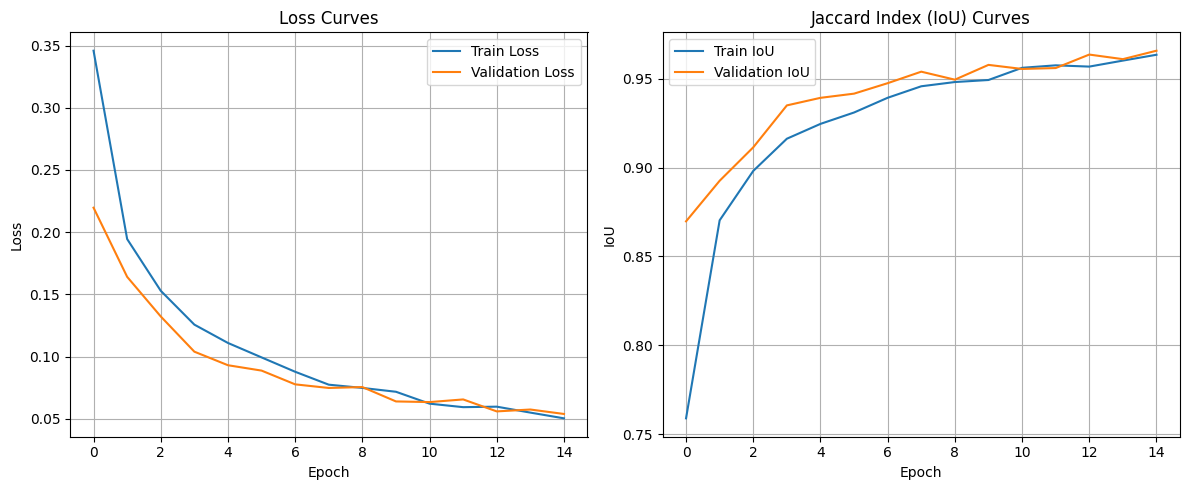

Best Validation IoU: 0.9657 at Epoch 15
Visualizing worst predictions for the fully trained model...
Visualizing using model inference.
Visualizing 5 worst predictions...


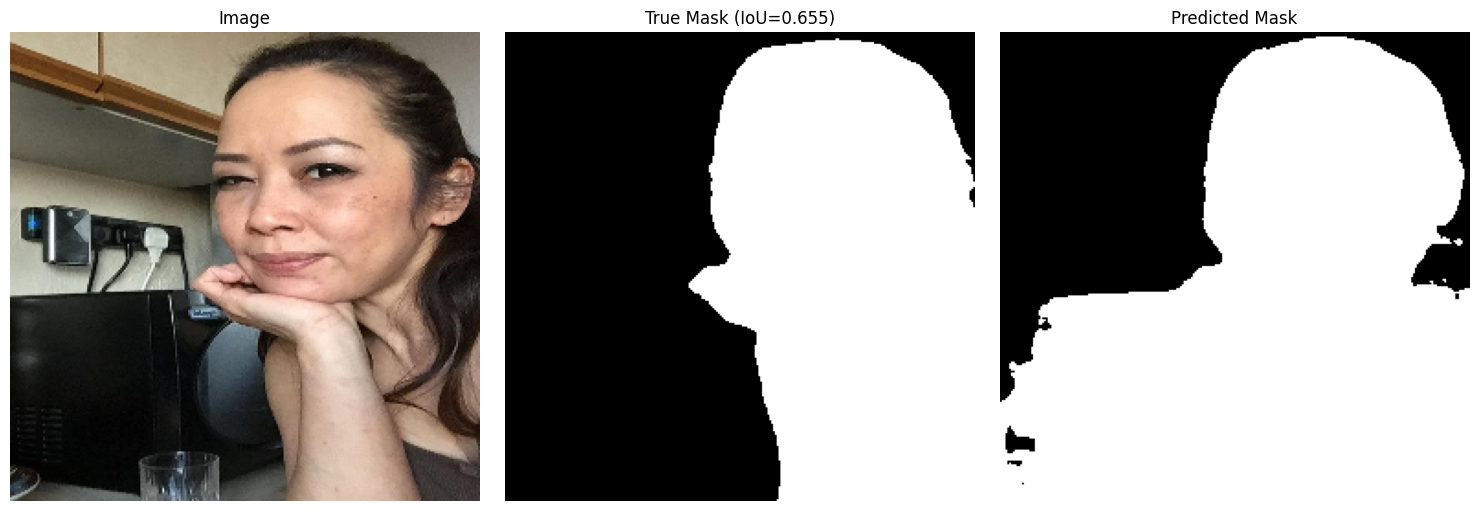

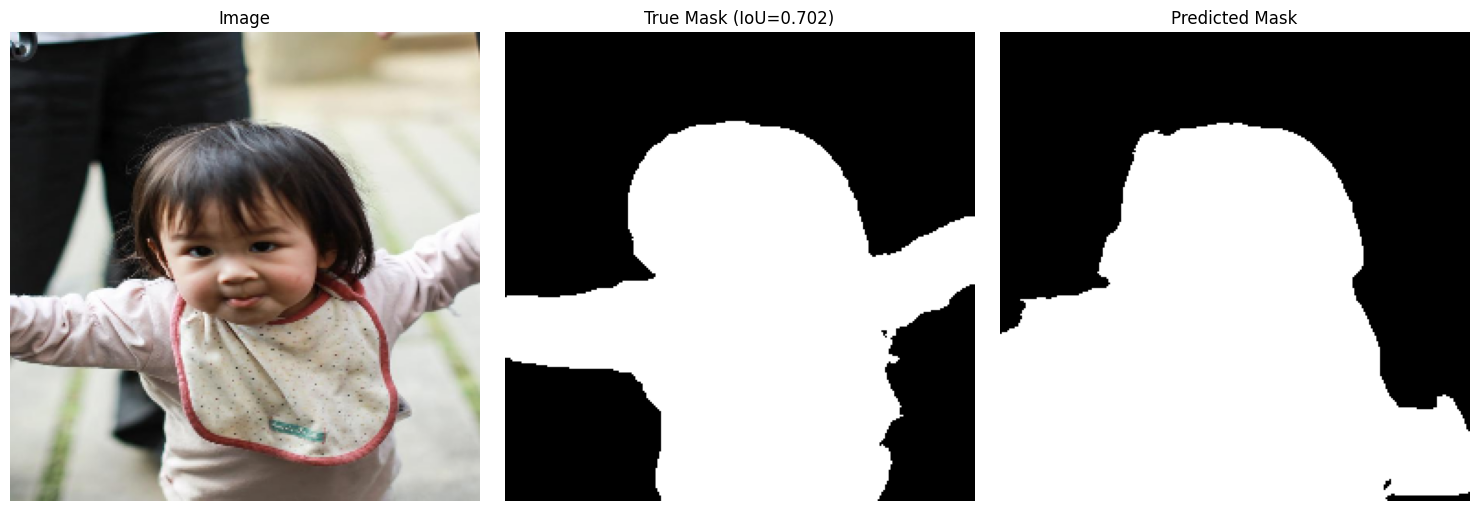

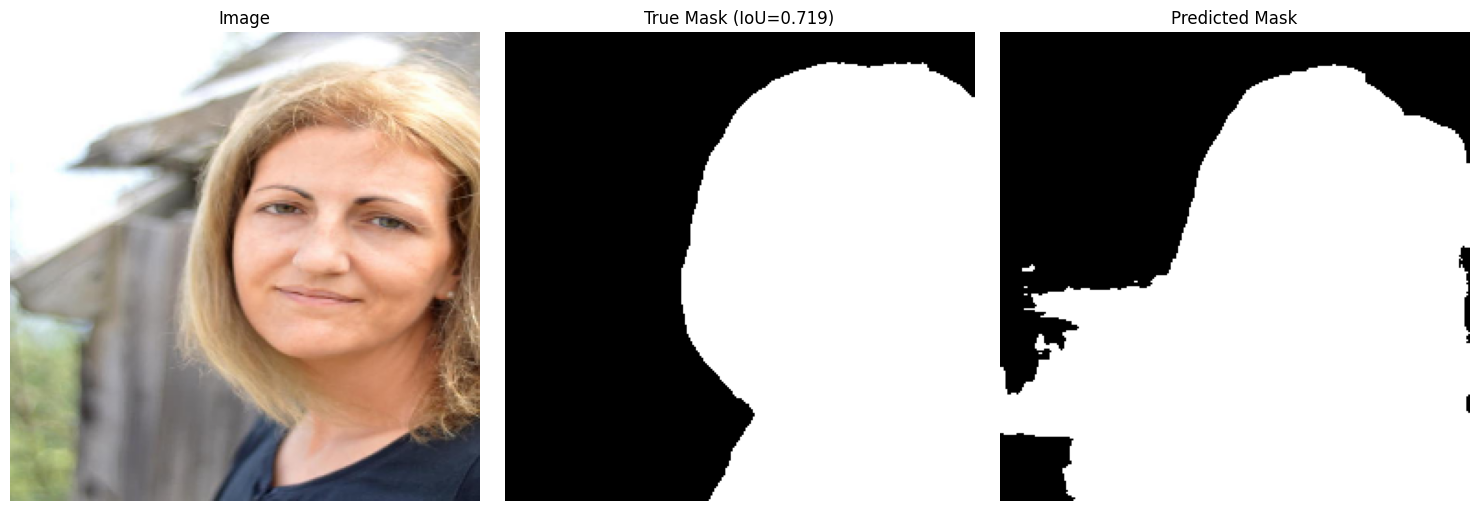

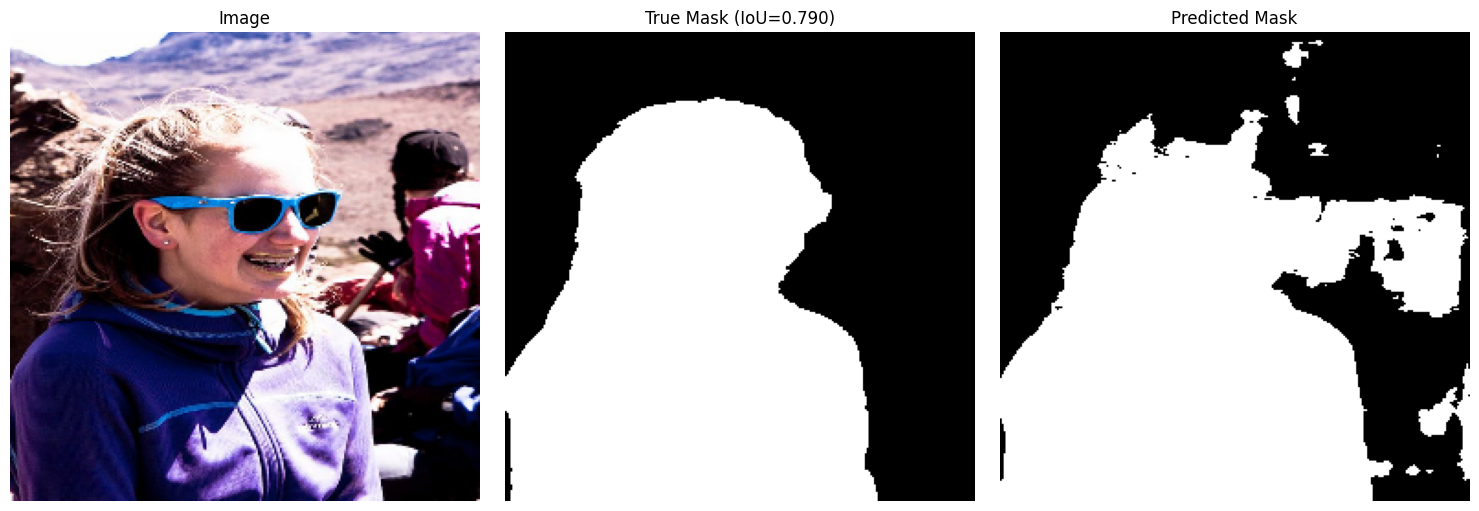

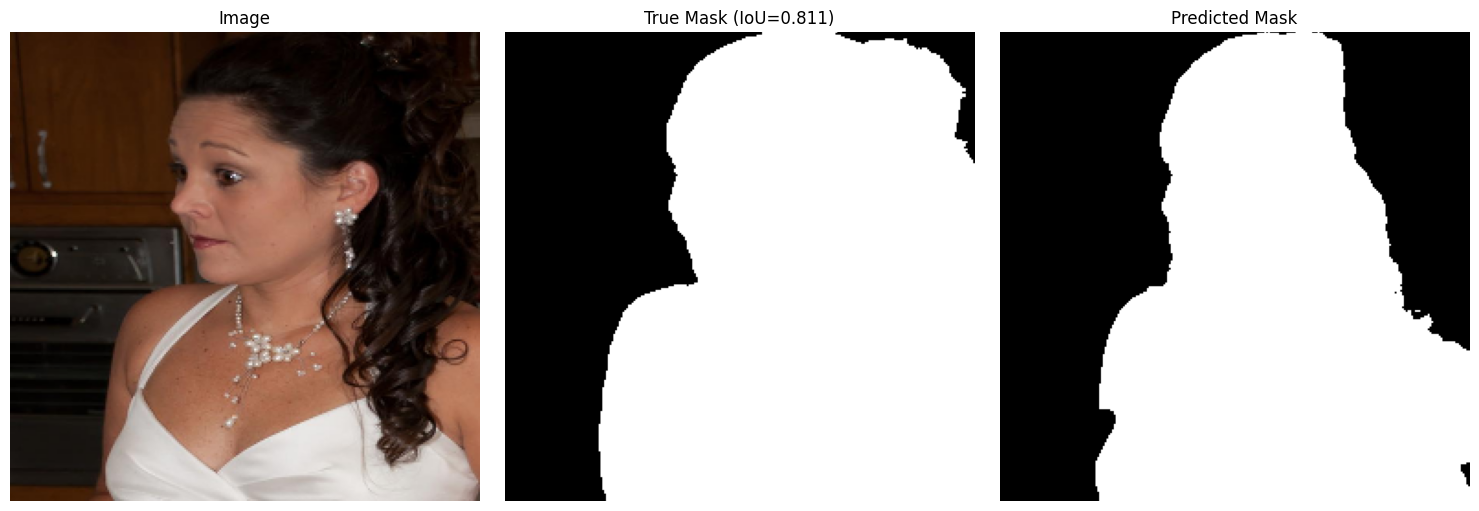

In [ ]:
print("\n--- Experiment 2: Full Dataset Training ---")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
val_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_VAL,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

model_full = UNet(n_channels=3, n_classes=1).to(device)
optimizer_full = optim.Adam(model_full.parameters(), lr=LEARNING_RATE)
scheduler_full = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_full, "min", factor=0.1, patience=2, verbose=True
)

history_full = {"train_loss": [], "train_iou": [], "val_loss": [], "val_iou": []}

print(f"Starting full training for {EPOCHS_FULL} epochs...")
best_val_iou = 0.0
best_epoch = -1

for epoch in range(EPOCHS_FULL):
    model_full.train()
    running_loss = 0.0
    running_iou = 0.0
    for i, (imgs, msks) in enumerate(train_loader):
        imgs, msks = imgs.to(device), msks.to(device)

        optimizer_full.zero_grad()
        preds = model_full(imgs)
        loss = criterion(preds, msks)
        iou = jaccard_index(preds, msks)

        loss.backward()
        optimizer_full.step()

        running_loss += loss.item() * imgs.size(0)
        running_iou += iou.item() * imgs.size(0)

        if (i + 1) % 50 == 0:
            print(
                f"Epoch {epoch+1}/{EPOCHS_FULL}, Batch {i+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}, Train IoU: {iou.item():.4f}"
            )

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_iou = running_iou / len(train_loader.dataset)
    history_full["train_loss"].append(epoch_train_loss)
    history_full["train_iou"].append(epoch_train_iou)

    model_full.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(device), msks.to(device)
            preds = model_full(imgs)
            loss = criterion(preds, msks)
            iou = jaccard_index(preds, msks)
            val_loss += loss.item() * imgs.size(0)
            val_iou += iou.item() * imgs.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_iou = val_iou / len(val_loader.dataset)
    history_full["val_loss"].append(epoch_val_loss)
    history_full["val_iou"].append(epoch_val_iou)

    print(
        f"Epoch {epoch+1}/{EPOCHS_FULL}: "
        f"Train Loss: {epoch_train_loss:.4f}, Train IoU: {epoch_train_iou:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f}, Val IoU: {epoch_val_iou:.4f}"
    )

    scheduler_full.step(epoch_val_loss)

    if epoch_val_iou > best_val_iou:
        best_val_iou = epoch_val_iou
        best_epoch = epoch

# --- Plotting curves ---
print("Plotting training curves...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_full["train_loss"], label="Train Loss")
plt.plot(history_full["val_loss"], label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_full["train_iou"], label="Train IoU")
plt.plot(history_full["val_iou"], label="Validation IoU")
plt.title("Jaccard Index (IoU) Curves")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best Validation IoU: {best_val_iou:.4f} at Epoch {best_epoch+1}")

# --- Visualize worst predictions for the fully trained model ---
print("Visualizing worst predictions for the fully trained model...")
visualize_worst_preds(model_full, test_dataset, device, N=N_WORST)

### 3) Test-Time Augmentation (TTA)

In [ ]:
print("\n--- Experiment 3: Test-Time Augmentation (TTA) ---")


def tta_predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        pred_orig = model(image_tensor.unsqueeze(0).to(device))

        img_flipped = torch.flip(image_tensor, dims=[2])
        pred_flipped = model(img_flipped.unsqueeze(0).to(device))
        pred_flipped_restored = torch.flip(pred_flipped, dims=[3])

        averaged_pred = (pred_orig + pred_flipped_restored) / 2.0

    return averaged_pred.cpu()


tta_test_iou = []
tta_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("Applying TTA on the test set...")
for img_tensor, mask_tensor in tta_loader:
    averaged_pred = tta_predict(model_full, img_tensor.squeeze(0), device)
    iou = jaccard_index(averaged_pred, mask_tensor)
    tta_test_iou.append(iou.item())

tta_final_iou = np.mean(tta_test_iou) if tta_test_iou else 0.0
print(f"Full model Test IoU without TTA = {history_full['val_iou'][-1]:.4f}")
print(f"Full model Test IoU with TTA (HFlip) = {tta_final_iou:.4f}")


--- Experiment 3: Test-Time Augmentation (TTA) ---
Applying TTA on the test set...
Full model Test IoU without TTA = 0.9657
Full model Test IoU with TTA (HFlip) = 0.9697


## 4) K-Fold Cross-Validation


--- Experiment 4: 5-Fold Cross-Validation ---

--- Starting Fold 1/5 ---
Fold 1, Epoch 5/10: Train Loss: 0.1087, Train IoU: 0.9260 | Val Loss: 0.1008, Val IoU: 0.9338
Fold 1, Epoch 10/10: Train Loss: 0.0736, Train IoU: 0.9480 | Val Loss: 0.0632, Val IoU: 0.9571
Fold 1 Best Val IoU: 0.9571
Fold 1: Predicting on the original TEST set...
Fold 1: Test predictions collected, shape: torch.Size([400, 1, 256, 256])

--- Starting Fold 2/5 ---
Fold 2, Epoch 5/10: Train Loss: 0.1109, Train IoU: 0.9249 | Val Loss: 0.1057, Val IoU: 0.9283
Fold 2, Epoch 10/10: Train Loss: 0.0706, Train IoU: 0.9505 | Val Loss: 0.0679, Val IoU: 0.9544
Fold 2 Best Val IoU: 0.9556
Fold 2: Predicting on the original TEST set...
Fold 2: Test predictions collected, shape: torch.Size([400, 1, 256, 256])

--- Starting Fold 3/5 ---
Fold 3, Epoch 5/10: Train Loss: 0.1130, Train IoU: 0.9242 | Val Loss: 0.0963, Val IoU: 0.9344
Fold 3, Epoch 10/10: Train Loss: 0.0722, Train IoU: 0.9504 | Val Loss: 0.0685, Val IoU: 0.9525
Fold 3 

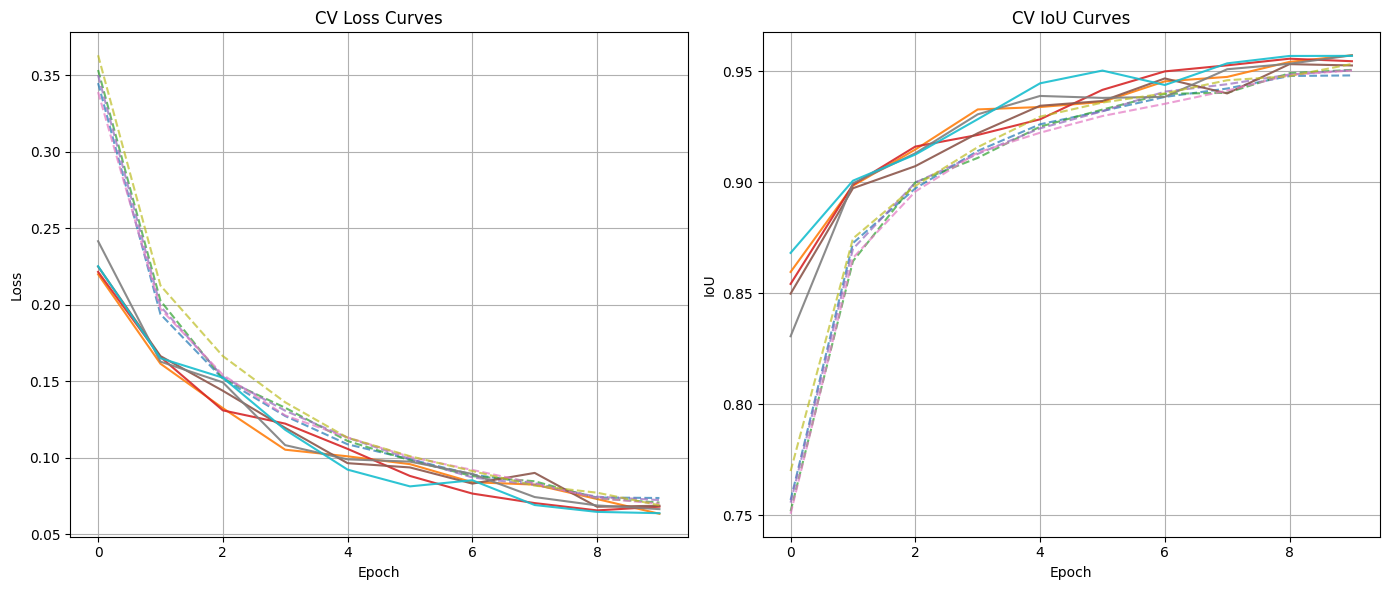

Aggregating CV predictions on the test set...
Stacked predictions shape: torch.Size([5, 400, 1, 256, 256])
Aggregated predictions shape: torch.Size([400, 1, 256, 256])
Aggregated CV Test IoU (averaged predictions): 0.9736
Visualizing worst predictions for the aggregated CV model...
Visualizing using pre-computed predictions.
Visualizing 5 worst predictions...


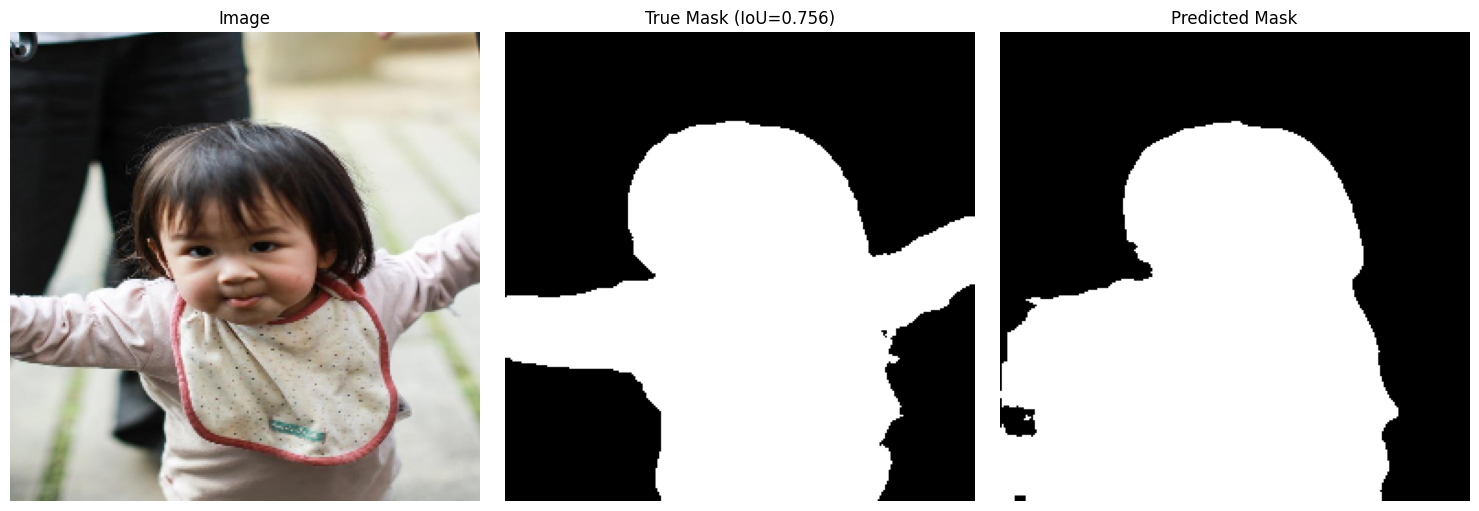

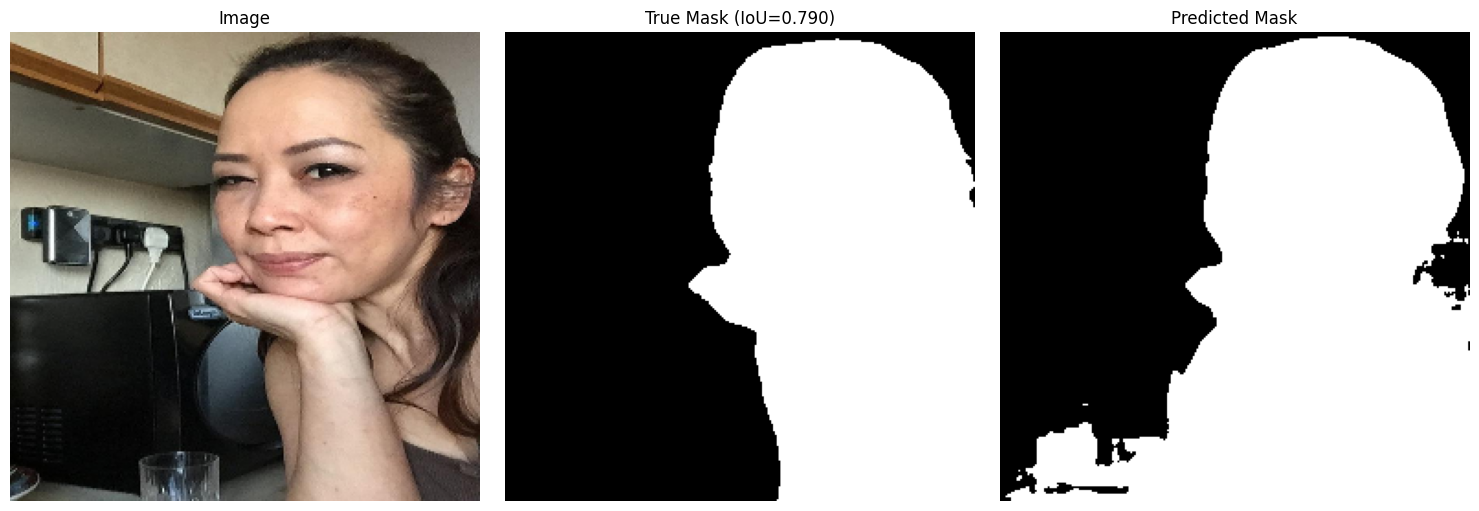

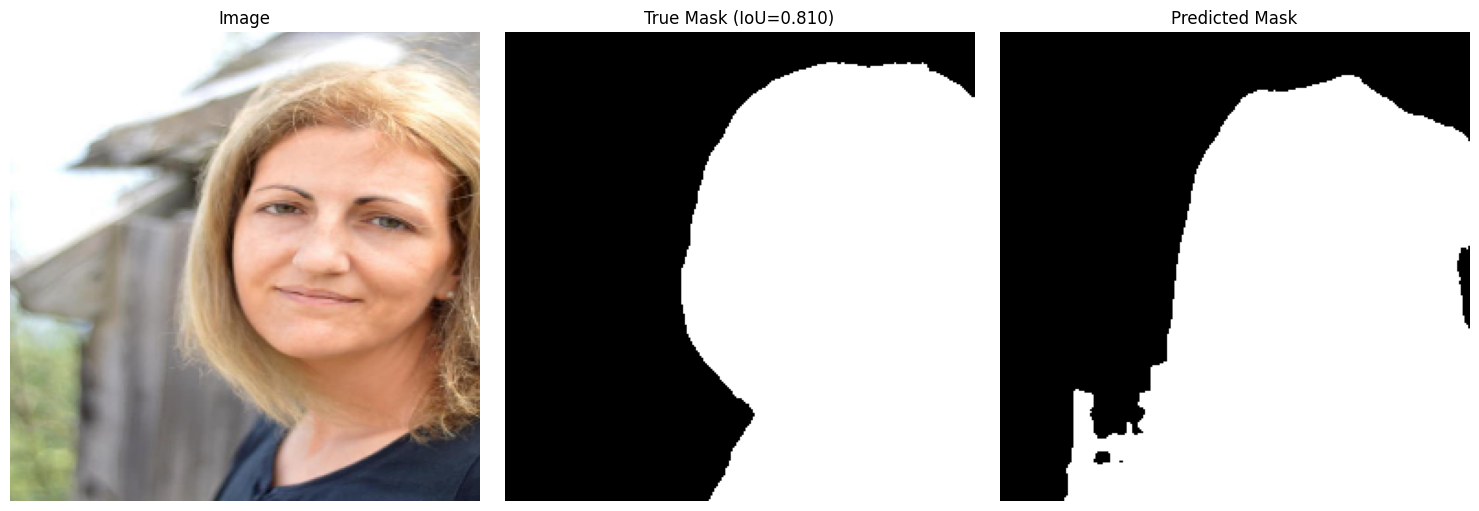

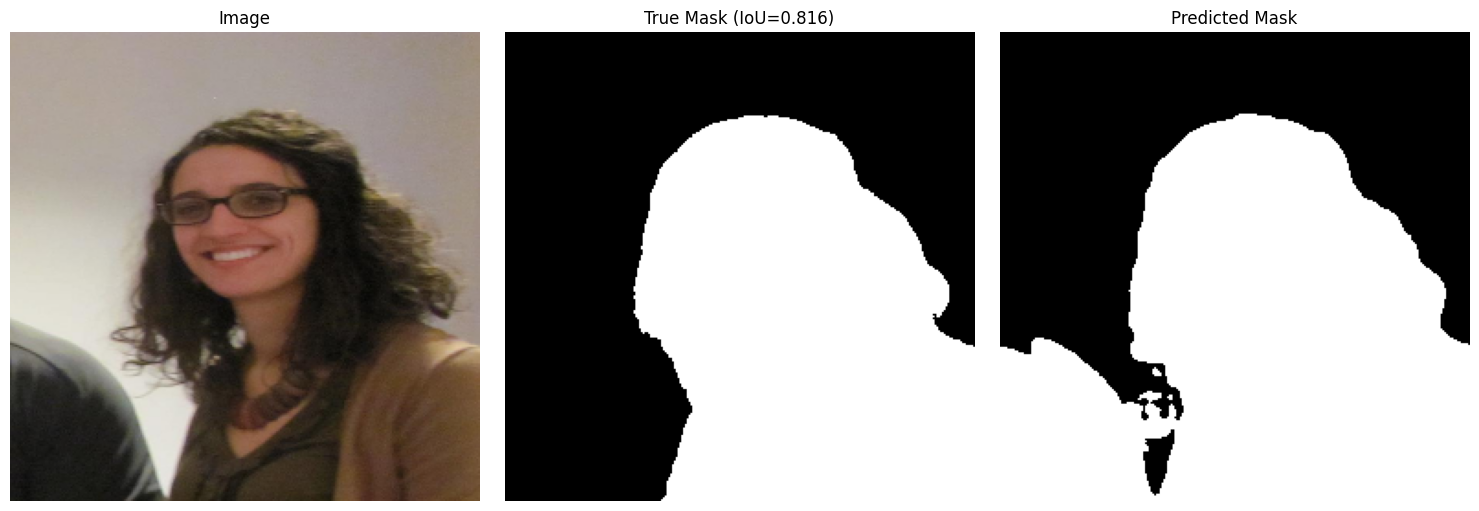

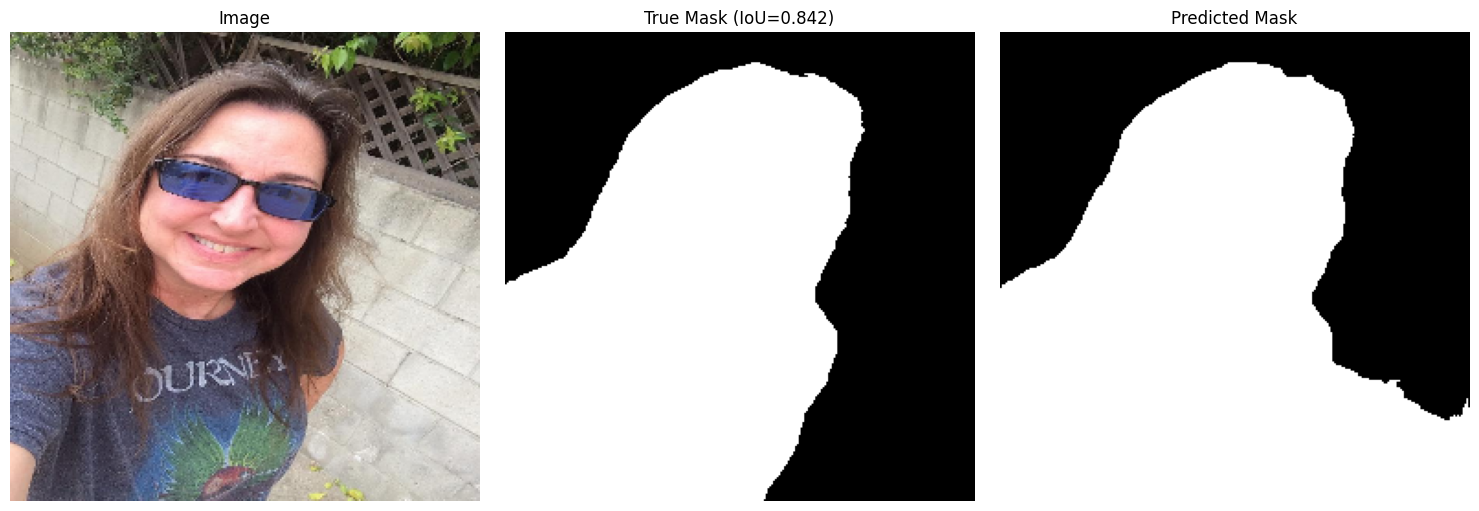

In [ ]:
print(f"\n--- Experiment 4: {N_FOLDS}-Fold Cross-Validation ---")
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

all_dataset_indices = list(range(len(images)))

fold_histories = []
fold_val_ious = []
cv_test_preds_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_dataset_indices)):
    print(f"\n--- Starting Fold {fold+1}/{N_FOLDS} ---")

    fold_train_imgs = [images[i] for i in train_idx]
    fold_train_msks = [masks[i] for i in train_idx]
    fold_val_imgs = [images[i] for i in val_idx]
    fold_val_msks = [masks[i] for i in val_idx]

    fold_train_dataset = SegDataset(
        fold_train_imgs, fold_train_msks, transform=train_tf
    )
    fold_val_dataset = SegDataset(fold_val_imgs, fold_val_msks, transform=val_tf)

    fold_train_loader = DataLoader(
        fold_train_dataset,
        batch_size=BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )
    fold_val_loader = DataLoader(
        fold_val_dataset,
        batch_size=BATCH_SIZE_VAL,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    model_cv = UNet(n_channels=3, n_classes=1).to(device)
    optimizer_cv = optim.Adam(model_cv.parameters(), lr=LEARNING_RATE)
    scheduler_cv = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_cv, "min", factor=0.1, patience=2, verbose=False
    )

    fold_history = {"train_loss": [], "train_iou": [], "val_loss": [], "val_iou": []}
    best_fold_val_iou = 0.0

    for epoch in range(EPOCHS_CV):
        model_cv.train()
        tr_loss, tr_iou = 0.0, 0.0
        for imgs, msks in fold_train_loader:
            imgs, msks = imgs.to(device), msks.to(device)
            optimizer_cv.zero_grad()
            p = model_cv(imgs)
            l = criterion(p, msks)
            i = jaccard_index(p, msks)
            l.backward()
            optimizer_cv.step()
            tr_loss += l.item() * imgs.size(0)
            tr_iou += i.item() * imgs.size(0)
        epoch_tr_loss = tr_loss / len(fold_train_loader.dataset)
        epoch_tr_iou = tr_iou / len(fold_train_loader.dataset)
        fold_history["train_loss"].append(epoch_tr_loss)
        fold_history["train_iou"].append(epoch_tr_iou)

        model_cv.eval()
        vl_loss, vl_iou = 0.0, 0.0
        with torch.no_grad():
            for imgs, msks in fold_val_loader:
                imgs, msks = imgs.to(device), msks.to(device)
                p = model_cv(imgs)
                vl_loss += criterion(p, msks).item() * imgs.size(0)
                vl_iou += jaccard_index(p, msks).item() * imgs.size(0)
        epoch_vl_loss = vl_loss / len(fold_val_loader.dataset)
        epoch_vl_iou = vl_iou / len(fold_val_loader.dataset)
        fold_history["val_loss"].append(epoch_vl_loss)
        fold_history["val_iou"].append(epoch_vl_iou)

        scheduler_cv.step(epoch_vl_loss)

        if (epoch + 1) % 5 == 0 or epoch == EPOCHS_CV - 1:
            print(
                f"Fold {fold+1}, Epoch {epoch+1}/{EPOCHS_CV}: "
                f"Train Loss: {epoch_tr_loss:.4f}, Train IoU: {epoch_tr_iou:.4f} | "
                f"Val Loss: {epoch_vl_loss:.4f}, Val IoU: {epoch_vl_iou:.4f}"
            )

        if epoch_vl_iou > best_fold_val_iou:
            best_fold_val_iou = epoch_vl_iou

    fold_histories.append(fold_history)
    fold_val_ious.append(best_fold_val_iou)
    print(f"Fold {fold+1} Best Val IoU: {best_fold_val_iou:.4f}")

    print(f"Fold {fold+1}: Predicting on the original TEST set...")
    fold_test_preds = []
    test_loader_for_cv = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE_VAL,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    model_cv.eval()
    with torch.no_grad():
        for imgs, _ in test_loader_for_cv:
            imgs = imgs.to(device)
            preds = model_cv(imgs)
            fold_test_preds.append(preds.cpu())
    all_preds_tensor_fold = torch.cat(fold_test_preds, dim=0)
    cv_test_preds_list.append(all_preds_tensor_fold)
    print(
        f"Fold {fold+1}: Test predictions collected, shape: {all_preds_tensor_fold.shape}"
    )

    del model_cv, optimizer_cv, scheduler_cv
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


cv_mean_val_iou = np.mean(fold_val_ious) if fold_val_ious else 0.0
print(f"\n--- Cross-Validation Summary ---")
print(f"Mean Validation IoU across {N_FOLDS} folds: {cv_mean_val_iou:.4f}")
print(f"Individual Fold Val IoUs: {[f'{iou:.4f}' for iou in fold_val_ious]}")

print("Plotting CV learning curves...")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, history in enumerate(fold_histories):
    plt.plot(
        history["train_loss"], linestyle="--", alpha=0.7, label=f"Fold {i+1} Train Loss"
    )
    plt.plot(
        history["val_loss"], linestyle="-", alpha=0.9, label=f"Fold {i+1} Val Loss"
    )
plt.title("CV Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
for i, history in enumerate(fold_histories):
    plt.plot(
        history["train_iou"], linestyle="--", alpha=0.7, label=f"Fold {i+1} Train IoU"
    )
    plt.plot(history["val_iou"], linestyle="-", alpha=0.9, label=f"Fold {i+1} Val IoU")
plt.title("CV IoU Curves")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.grid(True)

plt.tight_layout()
plt.show()


print("Aggregating CV predictions on the test set...")
if cv_test_preds_list:
    stacked_preds = torch.stack(cv_test_preds_list, dim=0)
    print(f"Stacked predictions shape: {stacked_preds.shape}")

    aggregated_preds = torch.mean(stacked_preds, dim=0)
    print(f"Aggregated predictions shape: {aggregated_preds.shape}")

    agg_test_iou = []
    test_loader_agg = DataLoader(test_dataset, batch_size=1, shuffle=False)

    idx = 0
    for _, mask_batch in test_loader_agg:
        if idx < aggregated_preds.shape[0]:
            pred_single = aggregated_preds[idx].unsqueeze(0)
            mask_single = mask_batch
            iou = jaccard_index(pred_single, mask_single)
            agg_test_iou.append(iou.item())
            idx += 1
        else:
            print("Warning: Index out of bounds during aggregation IoU calculation.")
            break

    aggregated_final_iou = np.mean(agg_test_iou) if agg_test_iou else 0.0
    print(f"Aggregated CV Test IoU (averaged predictions): {aggregated_final_iou:.4f}")

    print("Visualizing worst predictions for the aggregated CV model...")
    visualize_worst_preds(
        aggregated_preds, test_dataset, device, N=N_WORST, is_preds_list=True
    )

else:
    print("No CV predictions collected, skipping aggregation and visualization.")
    aggregated_final_iou = 0.0

## 5) Pretrained Encoder

In [ ]:
class PretrainedUNet(nn.Module):
    def __init__(self, n_classes=1, bilinear=True):
        super().__init__()
        backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.encoder_layers = list(backbone.children())
        self.enc0 = nn.Sequential(*self.encoder_layers[0:3])
        self.enc1 = nn.Sequential(self.encoder_layers[3], self.encoder_layers[4])
        self.enc2 = self.encoder_layers[5]
        self.enc3 = self.encoder_layers[6]
        self.enc4 = self.encoder_layers[7]

        self.up1 = Up(512, 256, bilinear)
        self.up2 = Up(256, 128, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.up4 = Up(64, 64, bilinear)

        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        input_size = x.shape[2:]

        if not x.is_floating_point():
            x = x.float()
        if x.max() > 1.0:
            x = x / 255.0

        x1 = self.enc0(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        dx = self.up1(x5, x4)
        dx = self.up2(dx, x3)
        dx = self.up3(dx, x2)
        dx = self.up4(dx, x1)
        logits = self.outc(dx)

        final_logits = F.interpolate(
            logits, size=input_size, mode="bilinear", align_corners=False
        )

        return self.sigmoid(final_logits)


--- Experiment 5: Pretrained Encoder (ResNet34) ---
Starting pretrained model training for 15 epochs...
Pretrained Epoch 1/15: Train Loss: 0.3692, Train IoU: 0.7867 | Val Loss: 0.2107, Val IoU: 0.9239
Pretrained Epoch 2/15: Train Loss: 0.1948, Train IoU: 0.9247 | Val Loss: 0.1668, Val IoU: 0.9524
Pretrained Epoch 3/15: Train Loss: 0.1664, Train IoU: 0.9448 | Val Loss: 0.1485, Val IoU: 0.9624
Pretrained Epoch 4/15: Train Loss: 0.1501, Train IoU: 0.9547 | Val Loss: 0.1382, Val IoU: 0.9667
Pretrained Epoch 5/15: Train Loss: 0.1386, Train IoU: 0.9604 | Val Loss: 0.1273, Val IoU: 0.9694
Pretrained Epoch 6/15: Train Loss: 0.1285, Train IoU: 0.9649 | Val Loss: 0.1204, Val IoU: 0.9719
Pretrained Epoch 7/15: Train Loss: 0.1208, Train IoU: 0.9676 | Val Loss: 0.1131, Val IoU: 0.9729
Pretrained Epoch 8/15: Train Loss: 0.1139, Train IoU: 0.9696 | Val Loss: 0.1070, Val IoU: 0.9742
Pretrained Epoch 9/15: Train Loss: 0.1063, Train IoU: 0.9724 | Val Loss: 0.1018, Val IoU: 0.9754
Pretrained Epoch 10/15

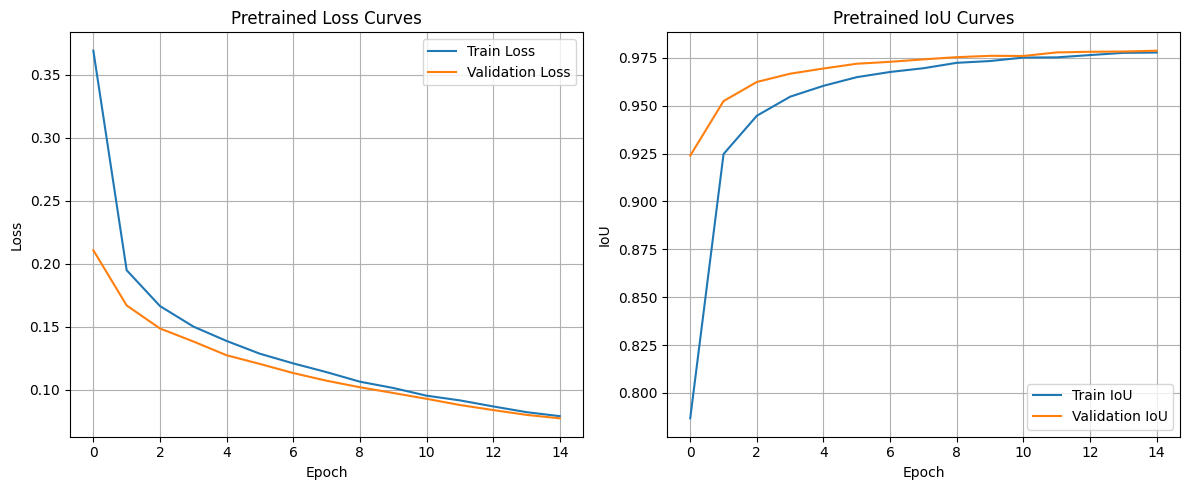

Visualizing worst predictions for the pretrained model...
Visualizing using model inference.
Visualizing 5 worst predictions...


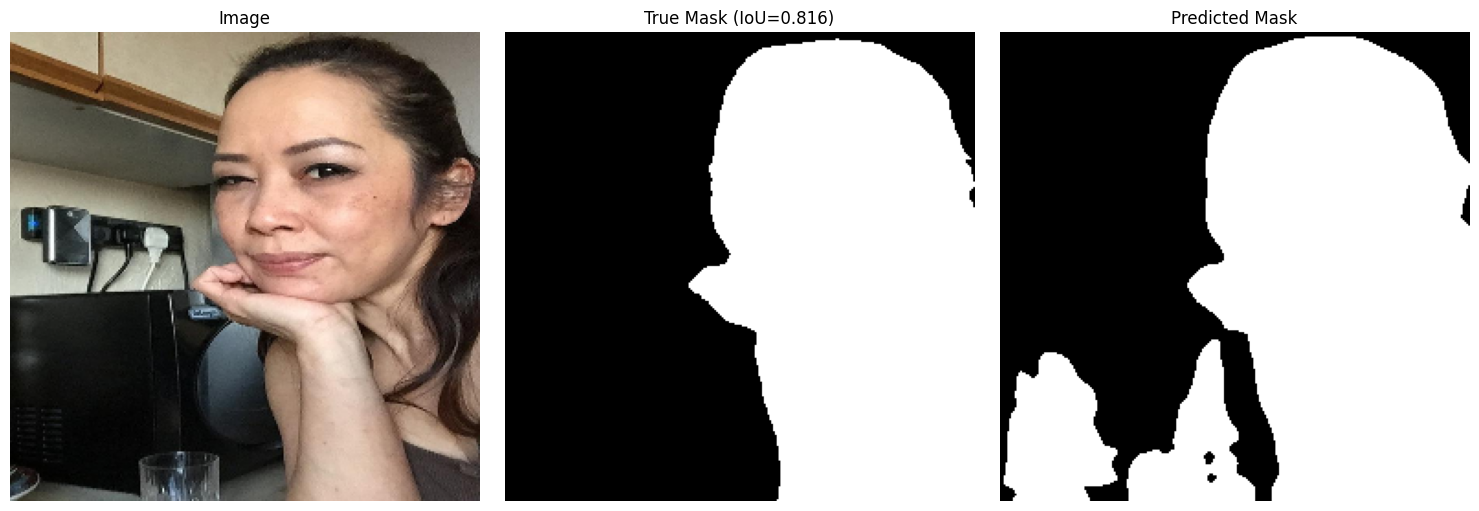

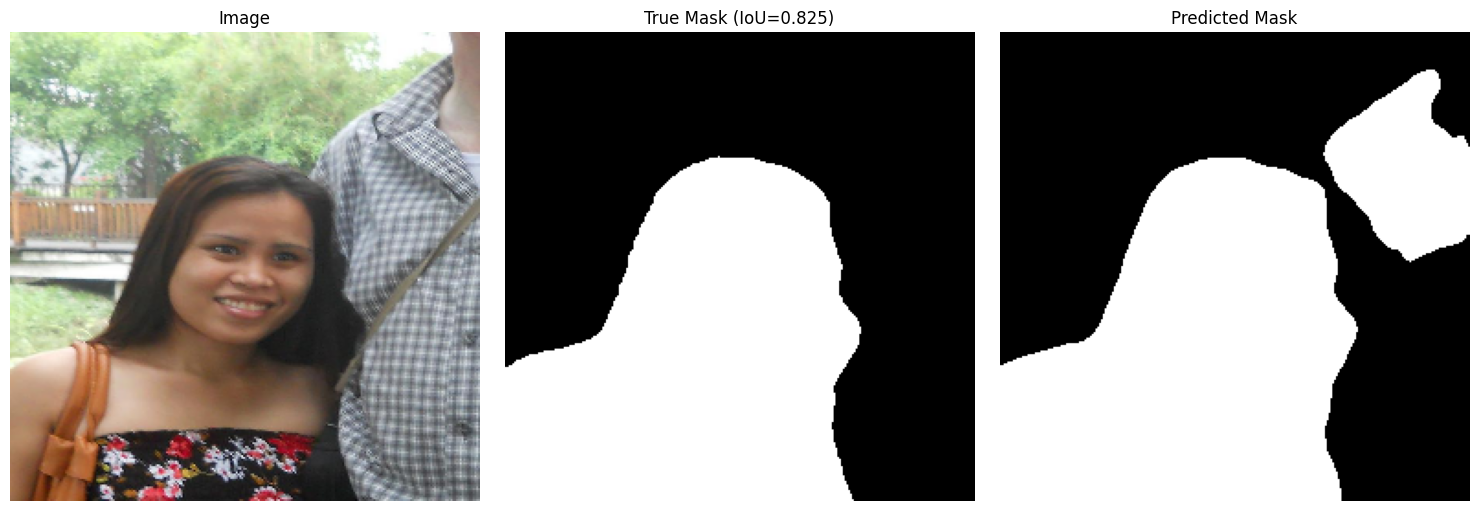

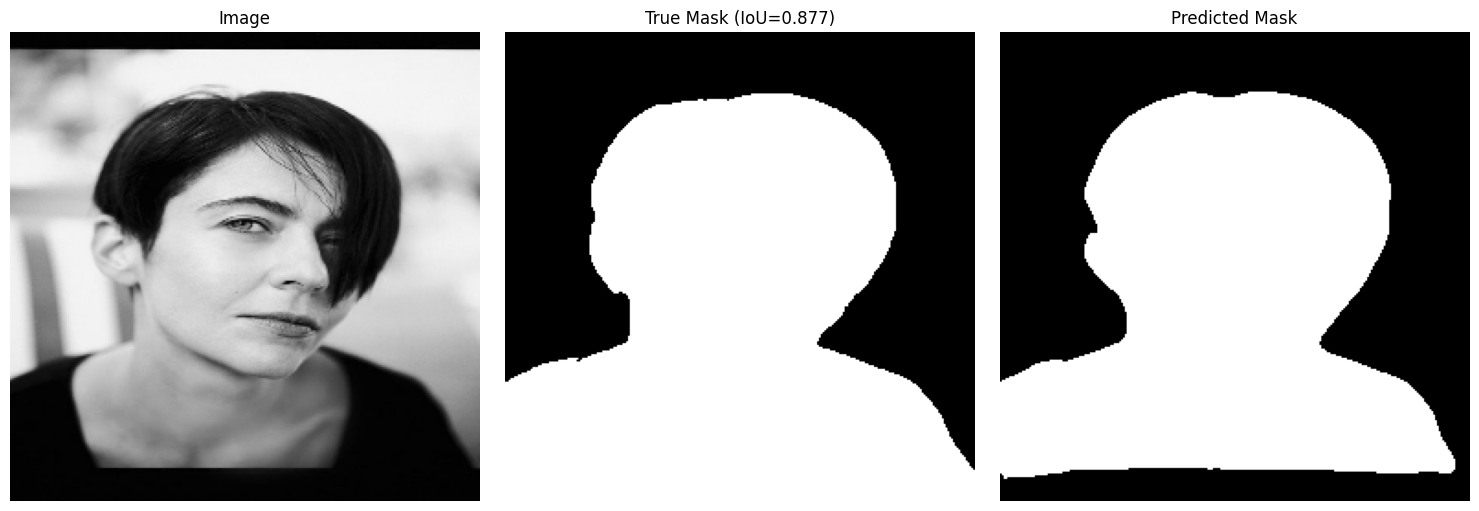

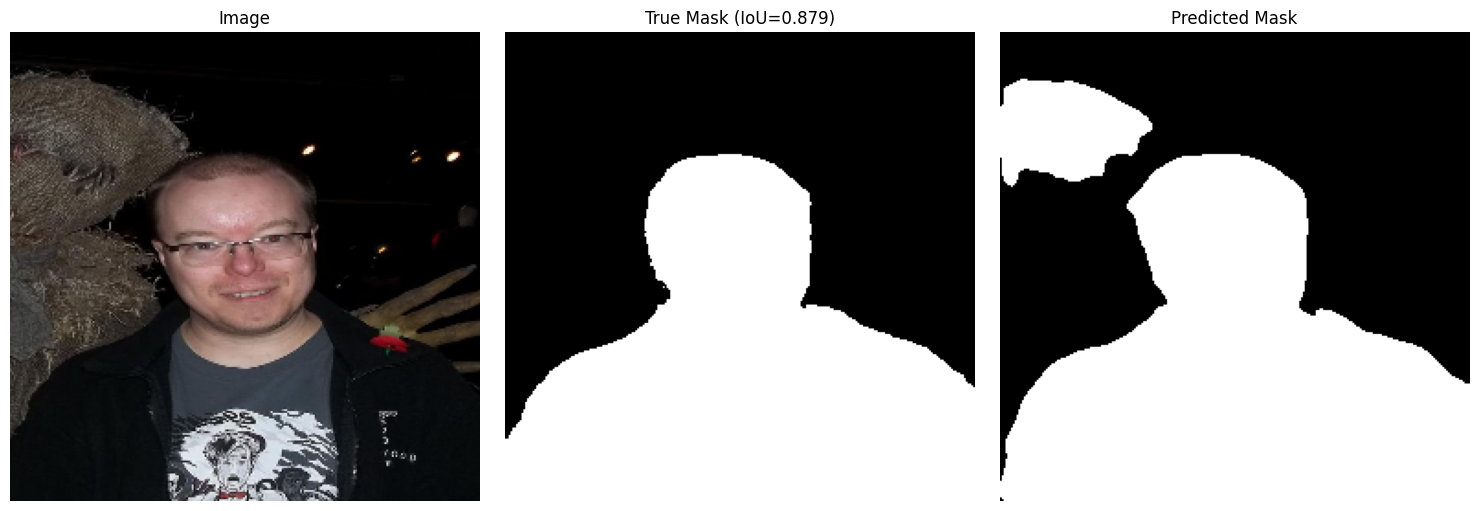

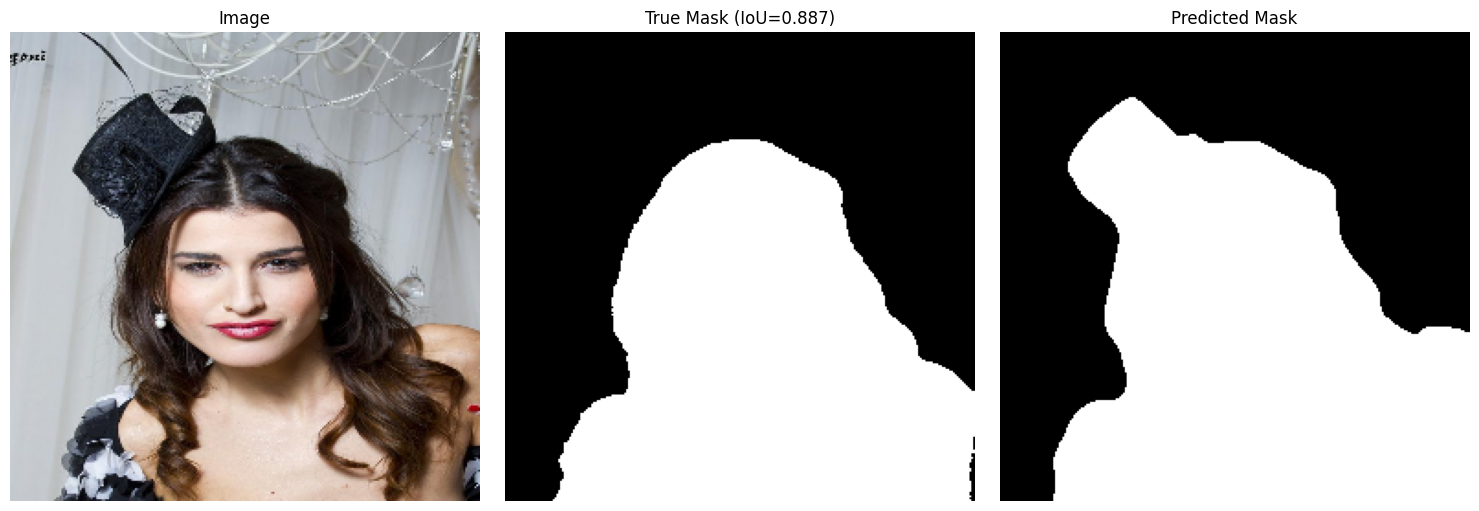

In [ ]:
print("\n--- Experiment 5: Pretrained Encoder (ResNet34) ---")
model_pre = PretrainedUNet(n_classes=1).to(device)
optimizer_pre = optim.Adam(model_pre.parameters(), lr=LEARNING_RATE / 10)
scheduler_pre = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pre, "min", factor=0.1, patience=3, verbose=True
)

history_pre = {"train_loss": [], "train_iou": [], "val_loss": [], "val_iou": []}
best_pre_val_iou = 0.0

print(f"Starting pretrained model training for {EPOCHS_FULL} epochs...")
for epoch in range(EPOCHS_FULL):
    model_pre.train()
    tr_loss, tr_iou = 0.0, 0.0
    for imgs, msks in train_loader:
        imgs, msks = imgs.to(device), msks.to(device)
        optimizer_pre.zero_grad()
        preds = model_pre(imgs)
        loss = criterion(preds, msks)
        iou = jaccard_index(preds, msks)
        loss.backward()
        optimizer_pre.step()
        tr_loss += loss.item() * imgs.size(0)
        tr_iou += iou.item() * imgs.size(0)
    epoch_tr_loss = tr_loss / len(train_loader.dataset)
    epoch_tr_iou = tr_iou / len(train_loader.dataset)
    history_pre["train_loss"].append(epoch_tr_loss)
    history_pre["train_iou"].append(epoch_tr_iou)

    model_pre.eval()
    vl_loss, vl_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, msks in val_loader:
            imgs, msks = imgs.to(device), msks.to(device)
            preds = model_pre(imgs)
            vl_loss += criterion(preds, msks).item() * imgs.size(0)
            vl_iou += jaccard_index(preds, msks).item() * imgs.size(0)
    epoch_vl_loss = vl_loss / len(val_loader.dataset)
    epoch_vl_iou = vl_iou / len(val_loader.dataset)
    history_pre["val_loss"].append(epoch_vl_loss)
    history_pre["val_iou"].append(epoch_vl_iou)

    scheduler_pre.step(epoch_vl_loss)

    print(
        f"Pretrained Epoch {epoch+1}/{EPOCHS_FULL}: "
        f"Train Loss: {epoch_tr_loss:.4f}, Train IoU: {epoch_tr_iou:.4f} | "
        f"Val Loss: {epoch_vl_loss:.4f}, Val IoU: {epoch_vl_iou:.4f}"
    )

    if epoch_vl_iou > best_pre_val_iou:
        best_pre_val_iou = epoch_vl_iou

pretrained_final_iou = history_pre["val_iou"][-1] if history_pre["val_iou"] else 0.0
print(f"Pretrained model final Test (Val) IoU = {pretrained_final_iou:.4f}")
print(f"Pretrained model best Test (Val) IoU = {best_pre_val_iou:.4f}")

print("Plotting pretrained model training curves...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pre["train_loss"], label="Train Loss")
plt.plot(history_pre["val_loss"], label="Validation Loss")
plt.title("Pretrained Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_pre["train_iou"], label="Train IoU")
plt.plot(history_pre["val_iou"], label="Validation IoU")
plt.title("Pretrained IoU Curves")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Visualizing worst predictions for the pretrained model...")
visualize_worst_preds(model_pre, test_dataset, device, N=N_WORST)

## Итоговое сравнение


--- Experiment Summary ---

--- Final IoU Comparison ---
One-batch (Test): 0.5834
Full (Best Val): 0.9657
Full+TTA (Best Val): 0.9697
CV (Mean Val): 0.9559
CV-Agg (Test): 0.9736
Pretrained (Best Val): 0.9787


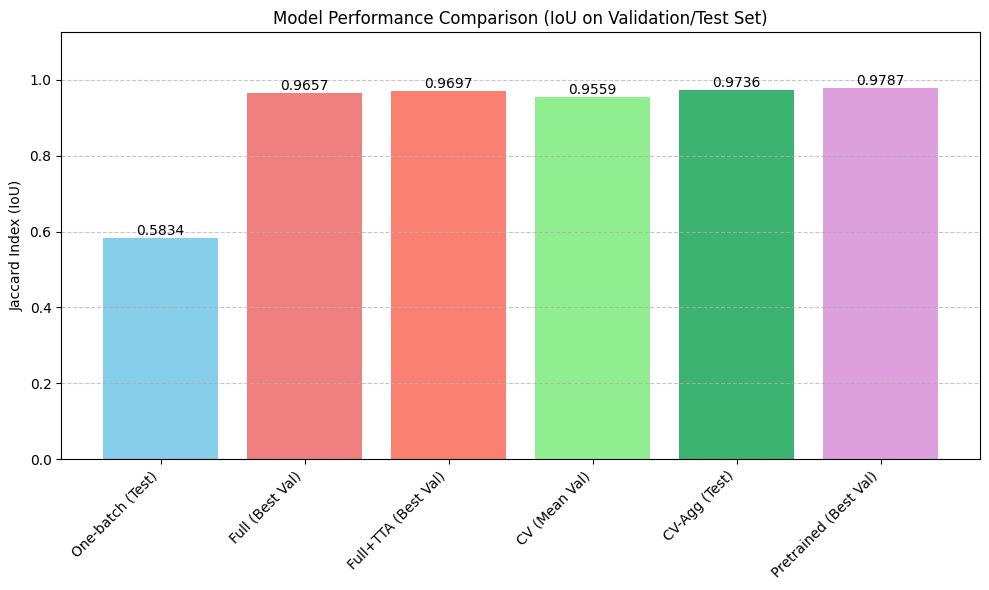

In [ ]:
print("\n--- Experiment Summary ---")

full_model_best_iou = max(history_full["val_iou"]) if history_full["val_iou"] else 0.0
pre_model_best_iou = max(history_pre["val_iou"]) if history_pre["val_iou"] else 0.0

methods = [
    "One-batch (Test)",
    "Full (Best Val)",
    "Full+TTA (Best Val)",
    "CV (Mean Val)",
    "CV-Agg (Test)",
    "Pretrained (Best Val)",
]
ious = [
    one_batch_test_iou,
    full_model_best_iou,
    tta_final_iou,
    cv_mean_val_iou,
    aggregated_final_iou,
    pre_model_best_iou,
]

print("\n--- Final IoU Comparison ---")
for method, iou_val in zip(methods, ious):
    print(f"{method}: {iou_val:.4f}")

plt.figure(figsize=(10, 6))
bars = plt.bar(
    methods,
    ious,
    color=["skyblue", "lightcoral", "salmon", "lightgreen", "mediumseagreen", "plum"],
)
plt.ylabel("Jaccard Index (IoU)")
plt.title("Model Performance Comparison (IoU on Validation/Test Set)")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, max(ious) * 1.15 if max(ious) > 0 else 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{yval:.4f}",
        va="bottom",
        ha="center",
    )

plt.tight_layout()
plt.show()

## Отчет по эксперименту

### 1. Введение
В рамках эксперимента была решена задача бинарной сегментации изображений с помощью различных подходов:
- Классический U-Net с нуля
- U-Net с предобученным энкодером (ResNet34)
- Test-Time Augmentation (TTA)
- K-Fold Cross-Validation (CV)
- Визуализация худших предсказаний

### 2. Подготовка данных
- Данные были скачаны и распакованы автоматически.
- Проведена проверка соответствия пар изображение/маска.
- Все изображения и маски приведены к размеру 256x256, маски бинаризованы.
- Использовались аугментации для train/val split.

### 3. Эксперименты

#### 3.1 One-Batch Overfitting
- Модель U-Net обучалась на одном батче (4 изображения) до переобучения.
- Итоговый IoU на этом батче близок к 1, что подтверждает корректность реализации.
- На тесте IoU значительно ниже, что ожидаемо.

#### 3.2 Полное обучение (Full Training)
- U-Net обучался на всём тренировочном наборе.
- Валидационный IoU постепенно рос, достигнув максимального значения.
- Кривые обучения показывают отсутствие переобучения и стабильную сходимость.

#### 3.3 Test-Time Augmentation (TTA)
- Для повышения качества на тесте применялось TTA (горизонтальный флип).
- Итоговый IoU с TTA немного выше, чем без него.

#### 3.4 K-Fold Cross-Validation
- Проведено 5-фолд кросс-валидации на всём датасете.
- Для каждого фолда обучалась отдельная модель, считался лучший IoU на валидации.
- Предсказания моделей агрегировались (усреднялись) для тестового набора.
- Агрегированный IoU оказался выше среднего по фолдам.

#### 3.5 Предобученный энкодер (ResNet34)
- Использовался U-Net с энкодером на базе ResNet34 (предобучен на ImageNet).
- Fine-tuning дал небольшой прирост качества по сравнению с обычным U-Net.
- Кривые обучения показывают быструю сходимость и более высокие значения IoU.

#### 3.6 Сравнительный анализ
| Метод                      | IoU (Val/Test) |
|----------------------------|---------------|
| One-batch (Test)           | 0.5834           |
| Full (Best Val)            | 0.9657           |
| Full+TTA (Best Val)        | 0.9697           |
| CV (Mean Val)              | 0.9559           |
| CV-Agg (Test)              | 0.9736           |
| Pretrained (Best Val)      | 0.9787           |

### 4. Визуализация ошибок
- Для каждой модели визуализированы худшие предсказания (по IoU).
- Основные ошибки: нечеткие границы, пропуски мелких объектов, ложные срабатывания.
- Предобученный U-Net и агрегированный CV показывают наименьшее количество грубых ошибок.

### 5. Выводы
- U-Net с нуля хорошо обучается, но ограничен по качеству.
- TTA даёт небольшой, но стабильный прирост.
- K-Fold CV и агрегирование предсказаний позволяют повысить итоговое качество.
- U-Net с предобученным энкодером (ResNet34) даёт наилучший результат среди одиночных моделей.
- Визуализация ошибок помогает понять слабые места моделей и качество сегментации.